## Final Project

-----

Name: Shiming Xiong & Betty Zhong

-----

---

Net id: sx368, hz1985

---

In [1]:
#import all potentially necessary packages for the project
import pandas as pd

In [2]:
%pylab inline 
import nltk
import json
import re
import time
import progressbar
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function
from six.moves import zip, range 
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import SnowballStemmer

import wordcloud 
from wordcloud import WordCloud

Populating the interactive namespace from numpy and matplotlib


In [3]:
#download the latest stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /nfshome/sx368/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Preparation
Here we start with data cleaning by removing any irrelevant abstract data. Data are removed by filtering through the ICT keywords list. 

In [4]:
#change directory to load dataset
%cd '~/projects/wagner_ada_2019/shared/Data'

/projects/wagner_ada_2019/shared/Data


In [5]:
#load abstract data 2017 into dataframe
abstracts = pd.read_csv('abstracts/FedRePORTER_PRJABS_C_FY2017.csv', encoding = "utf8") 
#keep only variables needed and remove any missing values
abstracts = abstracts.dropna()

In [6]:
#pull all descriptions and put them in numpy array
#create abstract_text for the purpose of topic modeling which only contains the text content of each abstract
abstract_text=abstracts[' ABSTRACT'].values

In [7]:
#checking to see the format of the dataset
abstracts.head(10)

,PROJECT_ID,ABSTRACT
0,919096,AbstractThe goal of this project is to build a...
1,919100,Doane College wishes to renovate parts of the ...
2,919104,DESCRIPTION (provided by applicant): As a resu...
3,919098,ADMINISTRATIONABSTRACTThe Knight Cancer Instit...
4,919097,﻿ DESCRIPTION (provided by applicant): The c...
5,919101,﻿ DESCRIPTION (provided by applicant): Allo...
6,919095,DESCRIPTION (provided by applicant): There are...
7,919099,The COBRE Center in Protein Structure and Func...
8,919103,Human immunodeficiency virus (HIV)-1 infection...
9,919108,DESCRIPTION (provided by applicant): Rising ra...


In [8]:
#tokenizing and spliting words to decide which ones are meaningful
tokens = abstract_text[0].split()

In [9]:
#show the tokenized results
tokens

[u'AbstractThe',
 u'goal',
 u'of',
 u'this',
 u'project',
 u'is',
 u'to',
 u'build',
 u'a',
 u'state-of-the-science',
 u'regional',
 u'center',
 u'of',
 u'research',
 u'excellence',
 u'in',
 u'Colombia,known',
 u'as',
 u'the',
 u'Stanford-Colombia',
 u'Collaboratory',
 u'on',
 u'Chronic',
 u'Disease',
 u'(S-C3),',
 u'whose',
 u'focus',
 u'is',
 u'on',
 u'the',
 u'prevention',
 u'ofmajor',
 u'non-communicable',
 u'diseases',
 u'(NCDs)',
 u'facing',
 u'Colombia',
 u'and',
 u'the',
 u'region,',
 u'including',
 u'cancer,',
 u'diabetes,cardiovascular',
 u'disease,',
 u'and',
 u'depression.',
 u'Physical',
 u'inactivity',
 u'is',
 u'one',
 u'of',
 u'the',
 u'most',
 u'important',
 u'contributors',
 u'to',
 u'theglobal',
 u'burden',
 u'of',
 u'NCDs,',
 u'responsible',
 u'for',
 u'~6-10%',
 u'of',
 u'major',
 u'NCDs',
 u'worldwide.',
 u'The',
 u'prevalence',
 u'of',
 u'physicalinactivity',
 u'and',
 u'sedentary',
 u'behavior',
 u'is',
 u'increasing',
 u'in',
 u'LMICs',
 u'and',
 u'approaching'

In [10]:
#create keywords list 1 for data cleaning to get ICT specific abstract data
keywords_list=['technology', 'digital', 'information communication','telecommunication', 'data service']

In [11]:
#create a new list named abstract_cleaning for storing abstracts filtered through the first keyword list
abstract_cleaning=[]

In [12]:
for keyword in keywords_list:   # for every keyword in the keyword list 
    for text in abstract_text:   #for text in the abstract text list
        if keyword in text.split(): # if a keyword is in a tokenized text      
            abstract_cleaning.append(text) #append such text in abstract_cleaning

In [13]:
#showing an abstract created with the for loop filtered by the keyword list
abstract_cleaning[0]

u"\ufeff   DESCRIPTION:   Basic and clinical research suggests there are extensive bidirectional interactions between circadian rhythms and addiction. Disruptions to the circadian system, either by environmental or genetic perturbation, may increase the vulnerability to addiction, while chronic drug use leads to circadian disruptions that persist during abstinence and may contribute to relapse. Although these relationships are intriguing, very little is known about the molecular  mechanisms  underlying  the  relationship  between  the  circadian  system  and  the  transition  to  addiction.  Animal studies have demonstrated that chronic exposure to cocaine leads to alterations in the expression and function of specific circadian genes (i.e., components of the molecular clock) in the mesolimbic dopamine reward system.  A major region of convergence for reward circuitry and a key substrate that regulates drug reward and motivation is the nucleus accumbens (NAc). The NAc is comprised of m

In [14]:
#number of abstract entries that are left after the clean up
len(abstract_cleaning)

7558

In [15]:
#introduce stopwords into analysis so these words will not be modelled during topic modeling
eng_stopwords = stopwords.words('english')
#add keywords to stopwords so that during topic modelling, we will get new keywords instead of also 
#seeing these five again
newStopWords=['technology', 'digital', 'information communication','telecommunication', 'data service']
#extending these new stopwords to the original stopwords list
eng_stopwords.extend(newStopWords)

In [16]:
#sample of stopwords
#this is an example of slicing where we implicitly start at the beginning and move to the end
#we select every 10th entry in the array
eng_stopwords[::10]

[u'i',
 u"you've",
 u'himself',
 u'they',
 u'that',
 u'been',
 u'a',
 u'while',
 u'through',
 u'in',
 u'here',
 u'few',
 u'own',
 u'just',
 u're',
 u'doesn',
 u'ma',
 u"shouldn't",
 'digital']

In [ ]:
stemmer = SnowballStemmer("english", 'keywords_list')

In [17]:
#creating bag of words for abstract_cleaning
def create_bag_of_words( abstract_cleaning,
                         NGRAM_RANGE = ( 0, 1 ),
                         stop_words = None,
                         stem = False,
                         MIN_DF = 0.05,
                         MAX_DF = 0.95,
                         USE_IDF = False ):
    
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
    stemmer = nltk.SnowballStemmer("english", "keywords_list")

    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words = vectorizer.fit_transform( abstract_cleaning ) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words)
        
        return tfidf, features
    else:
        return bag_of_words, features


In [18]:
# convert to bag of words
bag_of_words, features = create_bag_of_words(abstract_cleaning)

In [19]:
# taking a look at bag of words
bag_of_words

<7558x803 sparse matrix of type '<type 'numpy.int64'>'
	with 807640 stored elements in Compressed Sparse Row format>

In [20]:
#show all features derived from the corpus abstract_cleaning
features

[u'000',
 u'10',
 u'12',
 u'20',
 u'30',
 u'3d',
 u'ability',
 u'able',
 u'about',
 u'abstract',
 u'academic',
 u'access',
 u'accurate',
 u'achieve',
 u'across',
 u'active',
 u'activities',
 u'activity',
 u'addition',
 u'additional',
 u'address',
 u'addresses',
 u'advance',
 u'advanced',
 u'advances',
 u'after',
 u'against',
 u'age',
 u'aim',
 u'aims',
 u'algorithms',
 u'all',
 u'allow',
 u'allowing',
 u'allows',
 u'along',
 u'already',
 u'also',
 u'although',
 u'among',
 u'an',
 u'analyses',
 u'analysis',
 u'analyze',
 u'animal',
 u'any',
 u'applicant',
 u'application',
 u'applications',
 u'applied',
 u'apply',
 u'approach',
 u'approaches',
 u'appropriate',
 u'are',
 u'area',
 u'areas',
 u'around',
 u'array',
 u'art',
 u'as',
 u'aspects',
 u'assays',
 u'assess',
 u'assessment',
 u'associated',
 u'at',
 u'automated',
 u'available',
 u'award',
 u'based',
 u'basic',
 u'basis',
 u'be',
 u'because',
 u'become',
 u'been',
 u'behavior',
 u'behavioral',
 u'being',
 u'benefit',
 u'benefits',
 

In [21]:
#bag of words results in array format 
np_bag_of_words = bag_of_words.toarray()
np_bag_of_words

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]])

In [22]:
# get an ordered word count of bag_of_words
def get_word_counts( bag_of_words, feature_names ):

    # convert bag of words to array
    np_bag_of_words = bag_of_words.toarray()
    
    # calculate word count.
    word_count = np.sum(np_bag_of_words,axis=0)
    
    # convert to flattened array.
    np_word_count = np.asarray(word_count).ravel()
    
    # create dict of words mapped to count of occurrences of each word.
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    # Create ordered dictionary
    orddict_word_counts = OrderedDict( sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts

In [23]:
#get ordered word counts for abstract_cleaning
get_word_counts(bag_of_words, features)

OrderedDict([(u'will', 36466),
             (u'is', 26566),
             (u'that', 25458),
             (u'with', 24737),
             (u'this', 24040),
             (u'be', 18395),
             (u'by', 18000),
             (u'as', 16874),
             (u'on', 15979),
             (u'are', 15431),
             (u'research', 15378),
             (u'we', 13607),
             (u'technology', 12323),
             (u'project', 11918),
             (u'from', 11447),
             (u'an', 11084),
             (u'these', 9624),
             (u'at', 9447),
             (u'data', 9095),
             (u'have', 8841),
             (u'new', 8191),
             (u'or', 8005),
             (u'can', 7645),
             (u'our', 7460),
             (u'development', 7087),
             (u'which', 6856),
             (u'has', 6743),
             (u'based', 6430),
             (u'use', 6369),
             (u'high', 6229),
             (u'clinical', 6051),
             (u'cell', 6045),
             (u'their

In [24]:
#set bag of words with features
abstract_cleaning_bag_of_words, abstract_cleaning_features = create_bag_of_words(abstract_cleaning)

In [25]:
#get word count for each feature in the corpus 
get_word_counts( abstract_cleaning_bag_of_words, abstract_cleaning_features )

OrderedDict([(u'will', 36466),
             (u'is', 26566),
             (u'that', 25458),
             (u'with', 24737),
             (u'this', 24040),
             (u'be', 18395),
             (u'by', 18000),
             (u'as', 16874),
             (u'on', 15979),
             (u'are', 15431),
             (u'research', 15378),
             (u'we', 13607),
             (u'technology', 12323),
             (u'project', 11918),
             (u'from', 11447),
             (u'an', 11084),
             (u'these', 9624),
             (u'at', 9447),
             (u'data', 9095),
             (u'have', 8841),
             (u'new', 8191),
             (u'or', 8005),
             (u'can', 7645),
             (u'our', 7460),
             (u'development', 7087),
             (u'which', 6856),
             (u'has', 6743),
             (u'based', 6430),
             (u'use', 6369),
             (u'high', 6229),
             (u'clinical', 6051),
             (u'cell', 6045),
             (u'their

In [26]:
#get rid of the punctuations and set all characters to lowercase
RE_PREPROCESS = re.compile( r'\W+|\d+' ) 

#for a given piece of text ( "description" ) we invoke the `re.sub` command 
#the `re.sub` command takes 3 arguments: (1) the regular expression to match, 
#(2) what we want to substitute in place of that matching string (' ', a space)
#and (3) the text we want to apply this to. 
#we then invoke the `lower()` method on the output of the `re.sub` command
#to make all the remaining characters lowercase.
#the result is a list, where each entry in the list is a cleaned version of the
#corresponding entry in the original corpus.
#we then make the list into a numpy array to use it in analysis
processed_abstract_cleaning= np.array( [ re.sub( RE_PREPROCESS, ' ', description ).lower() for description in abstract_cleaning ] )

In [27]:
# create bag of words from processed_abstract_cleaning
processed_bag_of_words, processed_features = create_bag_of_words( processed_abstract_cleaning, stop_words = eng_stopwords )
dict_processed_word_counts = get_word_counts( processed_bag_of_words, processed_features )
dict_processed_word_counts

OrderedDict([(u'research', 15385),
             (u'project', 11928),
             (u'data', 9098),
             (u'new', 8192),
             (u'development', 7089),
             (u'based', 6430),
             (u'use', 6369),
             (u'high', 6229),
             (u'clinical', 6054),
             (u'cell', 6045),
             (u'using', 5807),
             (u'develop', 5499),
             (u'provide', 5403),
             (u'cells', 5376),
             (u'cancer', 5046),
             (u'also', 4904),
             (u'health', 4870),
             (u'system', 4755),
             (u'specific', 4751),
             (u'imaging', 4414),
             (u'aim', 4349),
             (u'studies', 4282),
             (u'study', 4208),
             (u'core', 4129),
             (u'human', 4093),
             (u'program', 3993),
             (u'students', 3947),
             (u'patients', 3929),
             (u'novel', 3836),
             (u'well', 3793),
             (u'disease', 3768),
           

## Below shows the first round of topic modeling results:

In [28]:
#function to create topics
def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features -> your bag of words
    features: feature list resulting out of BoW creation
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar:
        i=0
        lda = LatentDirichletAllocation( n_topics= N_TOPICS,
                                       learning_method='online') #create an object that will create 5 topics
        bar.update(i)
        i+=1
        doctopic = lda.fit_transform( tfidf )
        bar.update(i)
        i+=1
        
        ls_keywords = []
        for i,topic in enumerate(lda.components_):
            word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
            keywords = ', '.join( features[i] for i in word_idx)
            ls_keywords.append(text)
            print(i, keywords)
            bar.update(i)
            i+=1
            
    return ls_keywords, doctopic

In [29]:
#general format of topic modelling 
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, processed_features)

| 2 Elapsed Time: 0:00:32                                                      


0 cell, cells, cancer, imaging, specific
1 research, data, project, students, new
2 project, based, health, use, system


In [30]:
#topic modeling with restriction of 10 topics and 10 keywords in each topics
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                       N_TOPICS = 10,
                                                       N_TOP_WORDS= 10)

| 9 Elapsed Time: 0:00:43                                                      


0 brain, activity, social, behavior, use, neural, study, control, behavioral, data
1 dna, protein, sequencing, genome, proteins, rna, drug, gene, genetic, new
2 project, high, new, energy, design, system, research, systems, applications, devices
3 research, students, project, science, program, training, learning, education, new, university
4 research, core, data, center, investigators, projects, support, clinical, provide, development
5 data, analysis, understanding, study, methods, project, information, using, used, structural
6 disease, clinical, aim, blood, detection, patients, using, tissue, specific, develop
7 cancer, patients, treatment, clinical, tumor, risk, intervention, therapy, patient, imaging
8 cell, cells, human, specific, mouse, disease, expression, gene, aim, cellular
9 health, care, phase, project, based, use, development, cost, system, process


In [31]:
#5 topics 5 words each 
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                       N_TOPICS = 5,
                                                       N_TOP_WORDS= 5)

| 4 Elapsed Time: 0:00:38                                                      


0 health, patients, clinical, care, treatment
1 project, data, research, students, new
2 cell, cells, human, specific, protein
3 imaging, high, project, system, new
4 research, core, program, training, development


In [32]:
#8 topics 10 words each 
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                       N_TOPICS = 8,
                                                       N_TOP_WORDS= 10)

| 7 Elapsed Time: 0:00:41                                                      


0 phase, project, development, clinical, cost, drug, detection, commercial, high, process
1 protein, gene, dna, expression, specific, proteins, genetic, aim, molecular, function
2 cancer, patients, imaging, clinical, aim, treatment, tumor, tissue, brain, disease
3 data, research, project, students, science, learning, development, education, network, community
4 cell, cells, human, stem, single, immune, mouse, tissue, cellular, mice
5 health, care, use, study, based, intervention, risk, patients, outcomes, research
6 project, new, high, energy, systems, design, system, research, time, using
7 research, core, program, training, center, investigators, support, new, university, provide


## ITERATION 
Here we update the keyword list and do a final round of topic modeling after cleaning the dataset again using the final keyword list

In [33]:
#using keywords generated above
#update and strengthen the original keywords_list to generate the following keywords_list2
keywords_list2=['technology', 'digital', 'information communication','telecommunication', 'data service', 'model', 'network']

In [34]:
#create an empty final ict abstract list to store abstracts that have been filtered into the updated ICT keywords list
final_ict_abstract=[]

In [35]:
for item in keywords_list2: # for every keyword in the keyword list 
    for text in abstract_text:  #for text in the abstract text list
        if item in text.split():   # if a keyword is in a tokenized text  
            final_ict_abstract.append(text) #append such text in final_ict_abstract list

In [76]:
#create stopwords list 2
eng_stopwords2 = stopwords.words('english')
#adding keywords list 2 to stopwords and extend these words into the stopwords list
newStopWords2=['technology', 'digital', 'information communication','telecommunication', 'data service', 'model', 'network']
eng_stopwords2.extend(newStopWords2)

In [77]:
#sample of stopwords
#this is an example of slicing where we implicitly start at the beginning and move to the end
#we select every 10th entry in the array
eng_stopwords2[::10]

[u'i',
 u"you've",
 u'himself',
 u'they',
 u'that',
 u'been',
 u'a',
 u'while',
 u'through',
 u'in',
 u'here',
 u'few',
 u'own',
 u'just',
 u're',
 u'doesn',
 u'ma',
 u"shouldn't",
 'digital']

In [78]:
#create a new bag of words based the final ict abstract list 
#to differentiate the topic modelling process from the first data preping round
#every bag of words, features and topic modeling functions 
#will be denoted as create_bag_of_words2, features2 and so on 
def create_bag_of_words2( final_ict_abstract,
                         NGRAM_RANGE = ( 0, 1 ),
                         stop_words = None,
                         stem = False,
                         MIN_DF = 0.05,
                         MAX_DF = 0.95,
                         USE_IDF = False ):
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
    stemmer = nltk.SnowballStemmer("english", "keywords_list2")

    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words2 = vectorizer.fit_transform( final_ict_abstract ) #transform our corpus is a bag of words 
    features2 = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words2)
        
        return tfidf2, features2
    else:
        return bag_of_words2, features2


In [79]:
# convert to bag of words
bag_of_words2, features2 = create_bag_of_words(final_ict_abstract)

In [80]:
#taking a look at bag of words
bag_of_words2

<31547x774 sparse matrix of type '<type 'numpy.int64'>'
	with 3354027 stored elements in Compressed Sparse Row format>

In [81]:
#show what features are in the list
features2

[u'000',
 u'10',
 u'12',
 u'20',
 u'ability',
 u'able',
 u'about',
 u'abstract',
 u'academic',
 u'access',
 u'achieve',
 u'across',
 u'action',
 u'activation',
 u'active',
 u'activities',
 u'activity',
 u'acute',
 u'addition',
 u'additional',
 u'address',
 u'adult',
 u'advance',
 u'advanced',
 u'advances',
 u'affect',
 u'after',
 u'against',
 u'age',
 u'agents',
 u'aim',
 u'aims',
 u'all',
 u'allow',
 u'allows',
 u'along',
 u'also',
 u'although',
 u'among',
 u'an',
 u'analyses',
 u'analysis',
 u'analyze',
 u'animal',
 u'animals',
 u'anti',
 u'any',
 u'applicant',
 u'application',
 u'applications',
 u'applied',
 u'apply',
 u'approach',
 u'approaches',
 u'appropriate',
 u'are',
 u'area',
 u'areas',
 u'art',
 u'as',
 u'aspects',
 u'assays',
 u'assess',
 u'assessment',
 u'associated',
 u'at',
 u'available',
 u'award',
 u'based',
 u'basic',
 u'basis',
 u'be',
 u'because',
 u'become',
 u'been',
 u'behavior',
 u'behavioral',
 u'being',
 u'benefit',
 u'best',
 u'better',
 u'between',
 u'bindin

In [82]:
#bag of words results in array format
np_bag_of_words2 = bag_of_words2.toarray()
np_bag_of_words2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [83]:
#funtion for get word counts for words in bag of words
def get_word_counts2( bag_of_words2, feature_names2 ):

    # convert bag of words to array
    np_bag_of_words2 = bag_of_words2.toarray()
    
    # calculate word count.
    word_count2 = np.sum(np_bag_of_words2,axis=0)
    
    # convert to flattened array.
    np_word_count2 = np.asarray(word_count2).ravel()
    
    # create dict of words mapped to count of occurrences of each word.
    dict_word_counts2 = dict( zip(feature_names2, np_word_count2) )
    
    # Create ordered dictionary
    orddict_word_counts2 = OrderedDict( sorted(dict_word_counts2.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts2

In [84]:
#get ordered word counts for final_ict_abstract
get_word_counts2(bag_of_words2, features2)

OrderedDict([(u'will', 151745),
             (u'for', 135070),
             (u'that', 129087),
             (u'is', 120073),
             (u'with', 99006),
             (u'this', 95531),
             (u'by', 83894),
             (u'we', 79733),
             (u'as', 70492),
             (u'are', 69468),
             (u'be', 68923),
             (u'on', 64325),
             (u'research', 52326),
             (u'these', 48129),
             (u'from', 46516),
             (u'an', 46191),
             (u'have', 41151),
             (u'project', 40003),
             (u'our', 38584),
             (u'model', 37654),
             (u'at', 34574),
             (u'data', 34169),
             (u'or', 33977),
             (u'which', 33320),
             (u'cell', 32314),
             (u'cells', 32135),
             (u'development', 27886),
             (u'new', 27740),
             (u'can', 27318),
             (u'has', 26639),
             (u'aim', 26568),
             (u'specific', 25196),
       

In [85]:
#set bag of words2 with features
final_ict_abstract_bag_of_words2, final_ict_abstract_features2 = create_bag_of_words(final_ict_abstract)

In [86]:
#get word count for final ict abstract bag of words 
get_word_counts2( final_ict_abstract_bag_of_words2, final_ict_abstract_features2 )

OrderedDict([(u'will', 151745),
             (u'for', 135070),
             (u'that', 129087),
             (u'is', 120073),
             (u'with', 99006),
             (u'this', 95531),
             (u'by', 83894),
             (u'we', 79733),
             (u'as', 70492),
             (u'are', 69468),
             (u'be', 68923),
             (u'on', 64325),
             (u'research', 52326),
             (u'these', 48129),
             (u'from', 46516),
             (u'an', 46191),
             (u'have', 41151),
             (u'project', 40003),
             (u'our', 38584),
             (u'model', 37654),
             (u'at', 34574),
             (u'data', 34169),
             (u'or', 33977),
             (u'which', 33320),
             (u'cell', 32314),
             (u'cells', 32135),
             (u'development', 27886),
             (u'new', 27740),
             (u'can', 27318),
             (u'has', 26639),
             (u'aim', 26568),
             (u'specific', 25196),
       

In [87]:
#get rid of punctuations and set everything to lower
RE_PREPROCESS = re.compile( r'\W+|\d+' ) 

#for a given piece of text ( "description" ) we invoke the `re.sub` command 
#the `re.sub` command takes 3 arguments: (1) the regular expression to match, 
#(2) what we want to substitute in place of that matching string (' ', a space)
#and (3) the text we want to apply this to. 
#we then invoke the `lower()` method on the output of the `re.sub` command
#to make all the remaining characters lowercase.
#the result is a list, where each entry in the list is a cleaned version of the
#corresponding entry in the original corpus.
#we then make the list into a numpy array to use it in analysis
processed_final_ict_abstract= np.array( [ re.sub( RE_PREPROCESS, ' ', description ).lower() for description in final_ict_abstract ] )

In [88]:
# create bag of words from processed_final_ict_abstract
processed_bag_of_words2, processed_features2 = create_bag_of_words2( processed_final_ict_abstract, stop_words = eng_stopwords2 )
dict_processed_word_counts2 = get_word_counts2( processed_bag_of_words2, processed_features2 )
dict_processed_word_counts2

OrderedDict([(u'research', 52349),
             (u'project', 40041),
             (u'data', 34172),
             (u'cell', 32318),
             (u'cells', 32158),
             (u'development', 27890),
             (u'new', 27748),
             (u'aim', 27168),
             (u'specific', 25146),
             (u'studies', 24475),
             (u'using', 23946),
             (u'use', 22449),
             (u'also', 21539),
             (u'based', 21457),
             (u'disease', 21416),
             (u'clinical', 21170),
             (u'human', 21134),
             (u'provide', 19823),
             (u'study', 19743),
             (u'cancer', 18451),
             (u'high', 18397),
             (u'develop', 18100),
             (u'novel', 17833),
             (u'models', 17728),
             (u'health', 17441),
             (u'mechanisms', 16746),
             (u'system', 16560),
             (u'function', 16499),
             (u'patients', 16411),
             (u'well', 15748),
           

## Final round of topic modeling & Results: 

In [95]:
#topic function
def create_topics2(tfidf2, features2, N_TOPICS=3, N_TOP_WORDS=5):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features -> your bag of words
    features: feature list resulting out of BoW creation
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar2:
        i=0
        lda2 = LatentDirichletAllocation( n_topics= N_TOPICS,
                                       learning_method='online') #create an object that will create 5 topics
        bar2.update(i)
        i+=1
        doctopic2 = lda2.fit_transform( tfidf2 )
        bar2.update(i)
        i+=1
        
        ls_keywords2 = []
        for i,topic in enumerate(lda2.components_):
            word_idx2 = np.argsort(topic)[::-1][:N_TOP_WORDS]
            keywords2 = ', '.join( features2[i] for i in word_idx2)
            ls_keywords2.append(text)
            print(i, keywords2)
            bar2.update(i)
            i+=1
            
    return ls_keywords2, doctopic2

In [96]:
processed_bag_of_words2, processed_features2 = create_bag_of_words2(processed_final_ict_abstract,
                                                                    stop_words=eng_stopwords2,
                                                                    stem=True)

In [97]:
#general format of topic modelling 

processed_keywords2, processed_doctopic2 = create_topics2(processed_bag_of_words2, processed_features2)

| 2 Elapsed Time: 0:02:29                                                      


0 research, project, develop, data, program
1 cell, function, aim, studi, mechan
2 use, studi, clinic, patient, develop


In [102]:
#topic modeling of 8 topics and 10 keywords
processed_keywords2, processed_doctopic2 = create_topics2(processed_bag_of_words2, 
                                                       processed_features2, 
                                                       N_TOPICS = 6,
                                                       N_TOP_WORDS= 10)

| 5 Elapsed Time: 0:03:04                                                      


0 health, use, risk, studi, intervent, care, social, behavior, effect, outcom
1 research, program, train, develop, student, project, support, provid, core, scienc
2 function, activ, mechan, aim, signal, regul, studi, protein, role, cell
3 project, data, use, develop, system, comput, research, new, process, method
4 clinic, patient, develop, drug, use, treatment, studi, therapi, aim, imag
5 cell, gene, human, cancer, genet, infect, use, genom, diseas, express


In [99]:
#create dataframe final ict abstract and convert final_ict_abstract, which is a list, to a dataframe
df_final_ict_abstract = pd.DataFrame(final_ict_abstract, columns=['abstract'])

In [101]:
#checking the length of the dataframe
len(df_final_ict_abstract)

31547

## Record Linkage

In [55]:
#change directory to user directory for file saving purposes
%cd '~/projects/wagner_ada_2019/user/sx368'

/projects/wagner_ada_2019/user/sx368


In [56]:
#saving final ict abstract dataset to csv format
df_final_ict_abstract.to_csv(r"~/df_final_ict_abstract.csv", sep='\t',encoding='utf8')

In [57]:
#merge final ict abstract with original abstract dataset to get project id for ICT abstracts
#merging based on abstract column and non-ict abstracts will not be included in the final merged file
merge_abstract = df_final_ict_abstract.merge(abstracts, left_on='abstract', right_on=' ABSTRACT', how='left')

In [58]:
#checking the length of the merged abstract file
#notice the length is longer than the length of final ict abstract
#will have to delete any abstract duplicates later
len(merge_abstract)

38043

In [59]:
#taking a look at the format
merge_abstract.head(25)

,abstract,PROJECT_ID,ABSTRACT
0,﻿ DESCRIPTION: Basic and clinical research...,919113,﻿ DESCRIPTION: Basic and clinical research...
1,﻿ DESCRIPTION (provided by applicant): MRI p...,919117,﻿ DESCRIPTION (provided by applicant): MRI p...
2,The NCMI is dedicated to the advancement of cr...,919153,The NCMI is dedicated to the advancement of cr...
3,﻿ DESCRIPTION (provided by applicant): More ...,919131,﻿ DESCRIPTION (provided by applicant): More ...
4,﻿ DESCRIPTION: The treatment of osteochondr...,919143,﻿ DESCRIPTION: The treatment of osteochondr...
5,﻿ DESCRIPTION (provided by applicant): Micro...,919174,﻿ DESCRIPTION (provided by applicant): Micro...
6,﻿ DESCRIPTION (provided by applicant) Mercur...,919169,﻿ DESCRIPTION (provided by applicant) Mercur...
7,"ABSTRACTNearly 240,000 men are diagnosed with ...",919175,"ABSTRACTNearly 240,000 men are diagnosed with ..."
8,"ABSTRACTNearly 240,000 men are diagnosed with ...",949638,"ABSTRACTNearly 240,000 men are diagnosed with ..."
9,﻿ DESCRIPTION (provided by applicant): There...,919190,﻿ DESCRIPTION (provided by applicant): There...


In [60]:
#loading project data into grants dataframe
grants=pd.read_csv('/projects/wagner_ada_2019/shared/Data/projects/FedRePORTER_PRJ_C_FY2017.csv', encoding = "utf8")

In [61]:
#taking a look at grants data
grants.head(10)

,PROJECT_ID,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,...,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,919000,Abdomen; abdominal pressure; Acute Renal Fail...,A NOVEL DEVICE FOR OPTIMAL AND PERSONALIZED FL...,HHS,NIH,NIGMS,1R44GM123799-01,9/1/2017,8/31/2019,"BURNETT, DANIEL ROGERS",...,SAN FRANCISCO,CA,941072523,UNITED STATES,9/1/2017,8/31/2018,859.0,2017,1685221.0,NaN
1,919001,Address; Administrative Supplement; African A...,FLORIDA INTERNATIONAL UNIVERSITY-HEALTH DISPAR...,HHS,NIH,NIMHD,5S21MD010683-02,4/1/2016,3/31/2021,"GIL, ANDRES G",...,MIAMI,FL,331990001,UNITED STATES,4/1/2017,3/31/2018,307.0,2017,1900000.0,NaN
2,919002,affiliative behavior; Amygdaloid structure; A...,CHARACTERIZING THE (EPI)GENETICS OF OXYTOCIN R...,HHS,NIH,NICHD,1R01HD088007-01A1,2/14/2017,1/31/2022,"GREGORY, SIMON G",...,DURHAM,NC,277054673,UNITED STATES,2/14/2017,1/31/2018,865.0,2017,656021.0,NaN
3,919003,Acute; Acute Kidney Failure; Adverse event; a...,DEVELOPMENT OF FIBRIN-SPECIFIC NUCLEAR PROBE T...,HHS,NIH,NHLBI,1R42HL139342-01,9/1/2017,12/31/2017,"BLACKLEDGE, JAMES",...,SAINT LOUIS,MO,631464809,UNITED STATES,9/1/2017,12/31/2017,837.0,2017,151903.0,NaN
4,919004,Chemicals; Clinical Research; clinical resear...,CCTN - CONTRACEPTIVE CLINICAL TRIALS NETWORK -...,HHS,NIH,NICHD,275201300017I-7-27500001-1,6/26/2013,6/25/2018,"BORGATTA, LYNN",...,BOSTON,MA,021182908,UNITED STATES,NaN,NaN,NaN,2017,9413.0,NaN
5,919005,Affect; Age; Aging; Alzheimer disease prevent...,UCSD ALZHEIMER'S DISEASE RESEARCH CENTER P50,HHS,NIH,NIA,5P50AG005131-34,4/1/1997,3/31/2019,"BREWER, JAMES B",...,LA JOLLA,CA,920930934,UNITED STATES,5/1/2017,3/31/2018,866.0,2017,3411971.0,NaN
6,919006,apprenticeship; Area; Award; Cancer Center; C...,MOLECULAR GENETICS OF MELANOMA,HHS,NIH,NCI,5K24CA149202-08,5/1/2010,4/30/2020,"TSAO, HENSIN",...,BOSTON,MA,021142696,UNITED STATES,5/1/2017,4/30/2018,398.0,2017,171081.0,NaN
7,919007,Address; anticancer research; Award; Biomedic...,CORE E: INTEGRATED TRAINING AND EVALUATION COR...,HHS,NIH,NCI,5U54CA132383-10 (6947),NaN,NaN,"O'CONNELL, MARY A",...,LAS CRUCES,NM,880038002,UNITED STATES,9/1/2017,8/31/2018,NaN,2017,NaN,95949.0
8,919008,Adenylyl Imidodiphosphate; Algorithms; alpha ...,MAPPING THE CONFORMATIONAL CYCLE OF TRANSMEMBR...,HHS,NIH,NIGMS,5P01GM111126-03 (7638),NaN,NaN,"CHENG, YIFAN",...,SAN FRANCISCO,CA,941186215,UNITED STATES,8/1/2017,7/31/2018,NaN,2017,NaN,349251.0
9,919009,Address; Adherence; Adopted; Advanced Develop...,PRE-CLINICAL/CO-CLINICAL CORE,HHS,NIH,OD,5U54OD020351-03 (5019),NaN,NaN,"LUTZ, CATHLEEN M",...,BAR HARBOR,ME,046091500,UNITED STATES,7/1/2017,6/30/2018,NaN,2017,NaN,150074.0


In [62]:
#merge grants data with ict abstract to get the complete dataset
#merging based on project id and non-ict projects will not be included in the final dataframe
merge_grants_ict=merge_abstract.merge(grants, left_on='PROJECT_ID', right_on='PROJECT_ID', how='left')

In [63]:
#taking a look at the complete file
merge_grants_ict.head(10)

,abstract,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,...,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,﻿ DESCRIPTION: Basic and clinical research...,919113,﻿ DESCRIPTION: Basic and clinical research...,Abstinence; Acute; addiction; Alcohol or Othe...,GENERATING NOVEL MOUSE TOOLS TO INVESTIGATE BR...,HHS,NIH,NIDA,5R21DA041872-02,4/1/2016,...,PITTSBURGH,PA,152132303,UNITED STATES,4/1/2017,3/31/2018,279.0,2017,186767.0,NaN
1,﻿ DESCRIPTION (provided by applicant): MRI p...,919117,﻿ DESCRIPTION (provided by applicant): MRI p...,Acceleration; Algorithms; Aorta; Basic Scienc...,HIGHLY ACCELERATED SIMULTANEOUS MULTI-SLICE PH...,HHS,NIH,NIMH,5R44MH112210-02,8/1/2016,...,SEBASTOPOL,CA,954724266,UNITED STATES,8/1/2017,7/31/2018,242.0,2017,1369104.0,NaN
2,The NCMI is dedicated to the advancement of cr...,919153,The NCMI is dedicated to the advancement of cr...,Amyloid; Amyloid Proteins; Animals; Apoptosis...,3 D ELECTRON MICROSCOPY OF MACROMOLECULES,HHS,NIH,NIGMS,5P41GM103832-32,12/1/1996,...,HOUSTON,TX,770303411,UNITED STATES,1/1/2017,12/31/2017,859.0,2017,1899229.0,NaN
3,﻿ DESCRIPTION (provided by applicant): More ...,919131,﻿ DESCRIPTION (provided by applicant): More ...,arm; Biological Markers; Blood specimen; canc...,KRAS MUATIONS IN PLASMA CFDNA AS PREDICTOR TO ...,HHS,NIH,NCI,5R21CA202487-02,12/1/2015,...,HOUSTON,TX,770304009,UNITED STATES,12/1/2016,11/30/2018,394.0,2017,174000.0,NaN
4,﻿ DESCRIPTION: The treatment of osteochondr...,919143,﻿ DESCRIPTION: The treatment of osteochondr...,Address; Affect; Alpha Cell; Animal Model; ar...,OPPOSING RNAI MOLECULE GRADIENT CONSTRUCTS TO ...,HHS,NIH,NIAMS,5R01AR069564-02,6/1/2016,...,CLEVELAND,OH,441061712,UNITED STATES,6/1/2017,5/31/2018,846.0,2017,348700.0,NaN
5,﻿ DESCRIPTION (provided by applicant): Micro...,919174,﻿ DESCRIPTION (provided by applicant): Micro...,Address; Affinity; Arizona; Automation; base;...,AN INTEGRATED MICROARRAY PRINTING AND DETECTIO...,HHS,NIH,NIGMS,4R44GM114951-03,4/15/2015,...,TEMPE,AZ,852834045,UNITED STATES,5/1/2017,4/30/2018,859.0,2017,600000.0,NaN
6,﻿ DESCRIPTION (provided by applicant) Mercur...,919169,﻿ DESCRIPTION (provided by applicant) Mercur...,Achievement; Address; Aging; Air; Ammonium; a...,ON SITE MERCURY REMEDIATION VIA ACTIVATED FLY ASH,HHS,NIH,NIEHS,5R44ES024620-03,8/11/2014,...,LARAMIE,WY,820723037,UNITED STATES,1/1/2017,12/31/2018,143.0,2017,627244.0,NaN
7,"ABSTRACTNearly 240,000 men are diagnosed with ...",919175,"ABSTRACTNearly 240,000 men are diagnosed with ...",Address; Adverse effects; base; Base Sequence...,TRANSLATIONAL MOLECULAR AND CELLULAR IMAGING T...,HHS,NIH,NCI,5R33CA196458-02,8/4/2016,...,CHAMPAIGN,IL,618207406,UNITED STATES,8/1/2017,7/31/2018,394.0,2017,367076.0,NaN
8,"ABSTRACTNearly 240,000 men are diagnosed with ...",949638,"ABSTRACTNearly 240,000 men are diagnosed with ...",Address; Adverse effects; base; Base Sequence...,TRANSLATIONAL MOLECULAR AND CELLULAR IMAGING T...,HHS,NIH,NCI,3R33CA196458-02S1,8/4/2016,...,CHAMPAIGN,IL,618207406,UNITED STATES,8/1/2017,7/31/2018,394.0,2017,66508.0,NaN
9,﻿ DESCRIPTION (provided by applicant): There...,919190,﻿ DESCRIPTION (provided by applicant): There...,Acinetobacter baumannii; Acute; Address; Agre...,A FULLY INTEGRATED CENTRIFLUIDIC SYSTEM FOR DI...,HHS,NIH,NIAID,5R01AI117059-03,3/1/2015,...,IRWINDALE,CA,910103588,UNITED STATES,3/1/2017,2/28/2018,855.0,2017,704237.0,NaN


In [64]:
#notice the length is still longer than the ict abstract dataframe 
len(merge_grants_ict)

38043

In [65]:
#delete extra column of abstract
del merge_grants_ict['abstract']

In [66]:
#drop any duplicates if projects have the same abstract
#keep the first entry of any duplicates and delete the rest in the dataframe
merge_grants_ict.drop_duplicates(subset=' ABSTRACT', keep='first', inplace=True)

In [67]:
#checking the length of the dataframe, duplicates have been deleted
len(merge_grants_ict)

26240

## Graphing Final Results

In [68]:
#change directory to user directory
%cd '~/projects/wagner_ada_2019/user/sx368'

/projects/wagner_ada_2019/user/sx368


In [69]:
#save the final complete dataset that containts both abstract and grant information
merge_grants_ict.to_csv(r"~/merge_grants_ict.csv", sep='\t',encoding='utf8')

In [70]:
#import necessary visualization packages
import numpy as np
import matplotlib as mplib
import matplotlib.pyplot as plt 
import seaborn as sns          
# so images get plotted in the notebook
%matplotlib inline

In [71]:
#setting the axis range for the dataset 
#looking at each individual projects that are under a million dollars
fund = merge_grants_ict[merge_grants_ict[" FY_TOTAL_COST"] >= 0]

max_fund = fund[" FY_TOTAL_COST"].max()
print("Maximum funding = " + str(max_fund))

min_fund = fund[" FY_TOTAL_COST"].min()
print("Minimum funding = " + str(min_fund))

print((fund[" FY_TOTAL_COST"] < 1000000).value_counts())

#setting the limit for the variable we are looking at
fund_lim = fund[fund[" FY_TOTAL_COST"] < 1000000]

Maximum funding = 309811058.0
Minimum funding = 1.0
True     21318
False     1750
Name:  FY_TOTAL_COST, dtype: int64


In [72]:
#create df dataframe using merge grants ict data to make sure
#all organization states are US states and territories
df=merge_grants_ict[merge_grants_ict[' ORGANIZATION_STATE'].isin(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UM', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'])]

In [73]:
# Calculate total funding cost by year:
annual_fund_state= df.groupby(' ORGANIZATION_STATE')[' FY_TOTAL_COST'].sum().reset_index().sort_values([' FY_TOTAL_COST'], ascending= False)
annual_fund_state.columns = [' ORGANIZATION_STATE',' FY_TOTAL_COST']

In [74]:
#import figure for adjusting figure size
from matplotlib.pyplot import figure

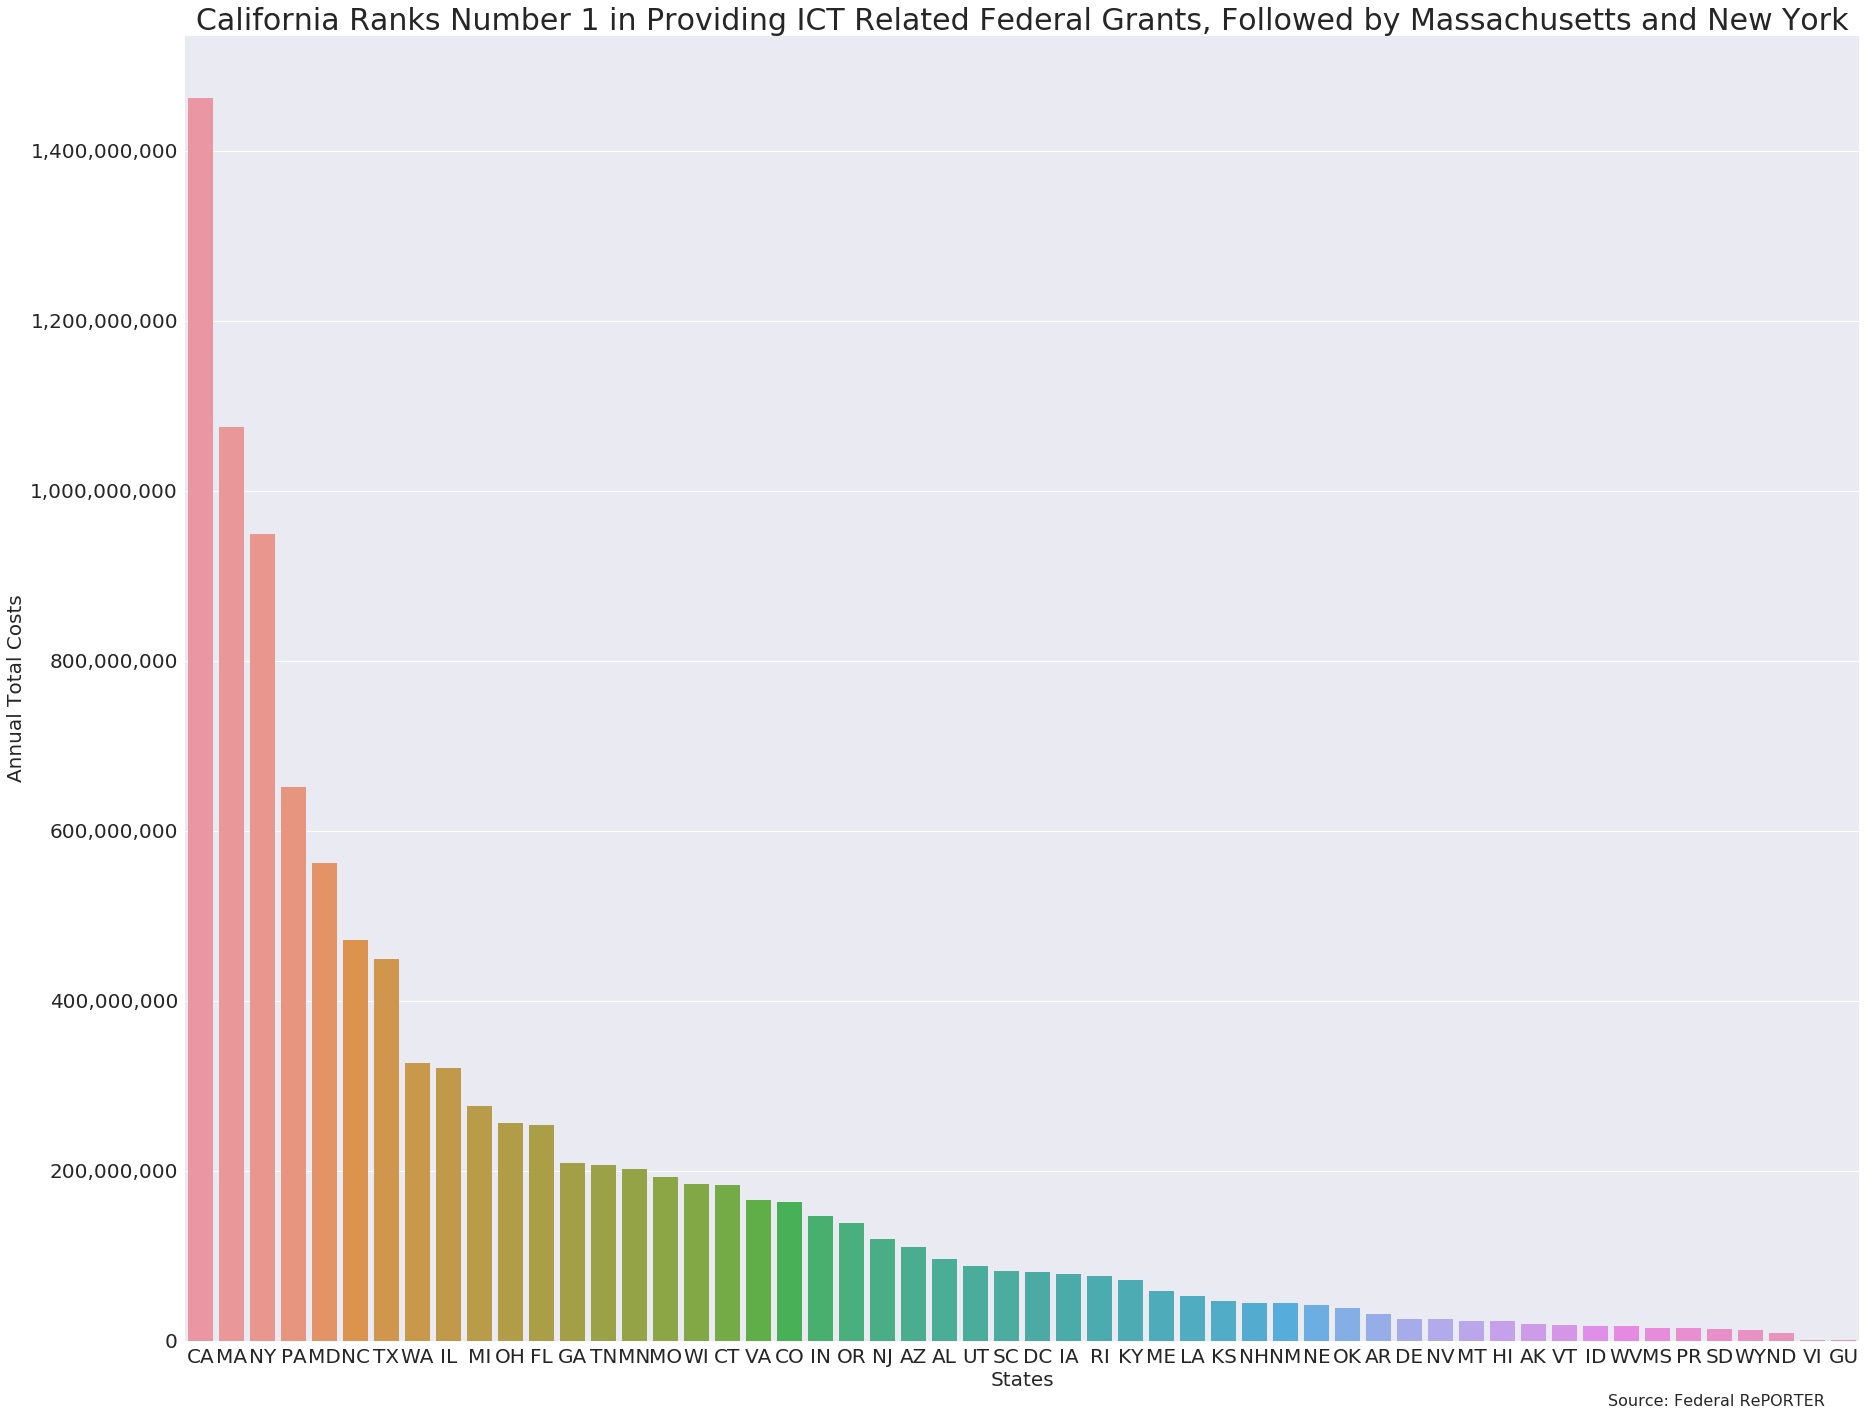

In [75]:
#setting the plotting, legend label size, figure size
#adding a story telling title to the graph
#make sure axes are clearly labeled and call for the right variable in the dataframe
#adjust font size to be legible 
#add source, show graph and save to png format
plt.figure(figsize=(30,24))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title('California Ranks Number 1 in Providing ICT Related Federal Grants, Followed by Massachusetts and New York', fontsize=30)
graph=sns.barplot(x=' ORGANIZATION_STATE', y=' FY_TOTAL_COST', data=annual_fund_state)
graph.set(xlabel='State', ylabel='Annual Total Costs')
graph.get_yaxis().set_major_formatter(mplib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('States', fontsize=20)
plt.ylabel('Annual Total Costs', fontsize=20)
plt.annotate('Source: Federal RePORTER', xy=(0.85,-0.05), xycoords="axes fraction", fontsize=16)
plt.show
plt.savefig('/projects/wagner_ada_2019/user/sx368/ICT Grant Allocation 2017.png')